In [1]:
#!pip install fastai
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
import seaborn as sns
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
from keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import * 
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Sequential

In [2]:
data = pd.read_csv('./datasets/fer2013.csv')

In [3]:
print(data.shape)
print(data.columns)
data.head()

(35887, 3)
Index(['emotion', 'pixels', 'Usage'], dtype='object')


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
data['pixels_graph'] = data['pixels'].apply (lambda x : x.split(' '))
data['pixels_graph'] = data['pixels_graph'].apply (lambda x : np.reshape(x, (48,48)))

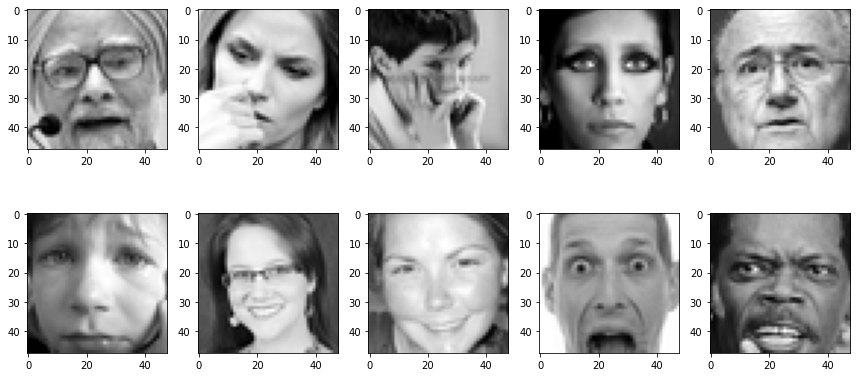

In [6]:
plt.figure(0, figsize=(12,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(data['pixels_graph'][i].astype(int), cmap = 'gray')
plt.tight_layout()
plt.show()

In [7]:
training = data.loc[data["Usage"] == "Training"]
public_test = data.loc[data["Usage"] == "PublicTest"]
private_test = data.loc[data["Usage"] == "PrivateTest"]

print("Training = ", training.shape)
print("Public_test = ", public_test.shape)
print("Private_test = ", private_test.shape)

Training =  (28709, 4)
Public_test =  (3589, 4)
Private_test =  (3589, 4)


In [8]:
train_labels = training["emotion"]
train_labels = to_categorical(train_labels)

val_labels = private_test["emotion"]
val_labels = to_categorical(val_labels)

test_labels = public_test["emotion"]
test_labels = to_categorical(test_labels)

In [9]:
train_images = training["pixels"].str.split(" ").tolist()
train_images = np.uint8(train_images)
train_images = train_images.reshape((train_images.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = private_test["pixels"].str.split(" ").tolist()
val_images = np.uint8(val_images)
val_images = val_images.reshape((val_images.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = private_test["pixels"].str.split(" ").tolist()
test_images = np.uint8(test_images)
test_images = test_images.reshape((test_images.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

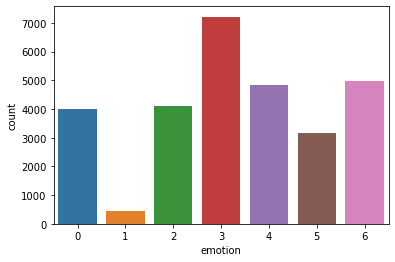

In [10]:
sns.countplot(training["emotion"])

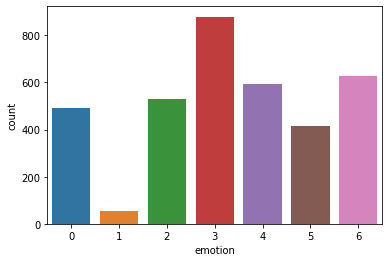

In [11]:
sns.countplot(private_test["emotion"])

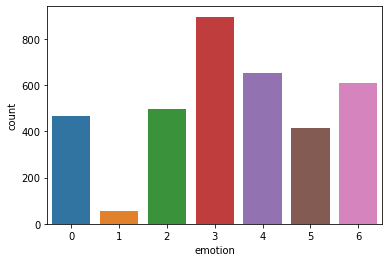

In [12]:
sns.countplot(public_test["emotion"])

In [13]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [14]:
datagen1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255,
    fill_mode='nearest')

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,)

In [16]:
datagen.fit(train_images)

In [17]:
model = models.Sequential()
model.add(Conv2D(64, (5, 5), activation='elu', padding = 'same', kernel_initializer = 'he_normal',input_shape=(48, 48, 1)))
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Conv2D(64, (5, 5), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_2'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Conv2D(128, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_4'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Conv2D(256, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_6'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization(name='batchnorm_7'))
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [19]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', min_delta = 0.00005, patience = 11, verbose = 1, restore_best_weights = True)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 7, min_lr = 1e-7, verbose = 1)

callbacks = [ early_stopping, lr_scheduler]

In [20]:
batch_size = 32

In [21]:
datagen.fit(train_images)

In [22]:
history = model.fit(datagen.flow(train_images , train_labels, batch_size= batch_size),
                    validation_data=(val_images, val_labels),
                    epochs=50,
                    steps_per_epoch = len(train_images)/batch_size,
                    callbacks = callbacks)

Epoch 1/50
897/897 [==============================] - 707s 784ms/step - loss: 2.3701 - accuracy: 0.2090 - val_loss: 1.6592 - val_accuracy: 0.3346
Epoch 2/50
897/897 [==============================] - 522s 581ms/step - loss: 1.7232 - accuracy: 0.3116 - val_loss: 1.4721 - val_accuracy: 0.4302
Epoch 3/50
897/897 [==============================] - 522s 582ms/step - loss: 1.5699 - accuracy: 0.3905 - val_loss: 1.4609 - val_accuracy: 0.4606
Epoch 4/50
897/897 [==============================] - 519s 579ms/step - loss: 1.4308 - accuracy: 0.4514 - val_loss: 1.3947 - val_accuracy: 0.4820
Epoch 5/50
897/897 [==============================] - 518s 577ms/step - loss: 1.3573 - accuracy: 0.4815 - val_loss: 1.2633 - val_accuracy: 0.5077
Epoch 6/50
897/897 [==============================] - 519s 579ms/step - loss: 1.3046 - accuracy: 0.5017 - val_loss: 1.1841 - val_accuracy: 0.5548
Epoch 7/50
897/897 [==============================] - 524s 584ms/step - loss: 1.2649 - accuracy: 0.5296 - val_loss: 1.1955 -

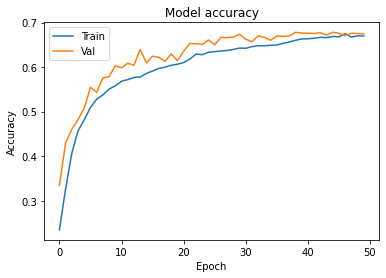

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

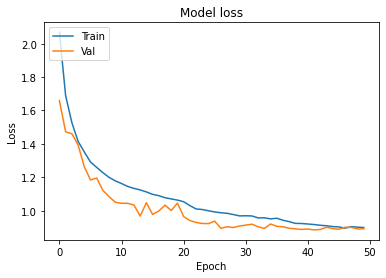

In [24]:
# Plot training and test loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left') 
plt.show()

In [2]:
model.save('/modelo_score_+60.h5')